In [97]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import models, layers

stopwords = stopwords.words('english')

In [2]:
train_path = os.path.join('disaster_or_not', 'train.csv')
train_df = pd.read_csv(train_path)
test_path = os.path.join('disaster_or_not', 'test.csv')
test_df = pd.read_csv(test_path)
print('Shape of data: ', train_df.shape)
train_df.head()

Shape of data:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print('Train data:')
print((train_df.isna().sum() / train_df.count()).round(4) * 100)
print()
print('Test data:')
print((test_df.isna().sum() / test_df.count()).round(4) * 100)

Train data:
id           0.00
keyword      0.81
location    49.86
text         0.00
target       0.00
dtype: float64

Test data:
id           0.0
keyword      0.8
location    51.2
text         0.0
dtype: float64


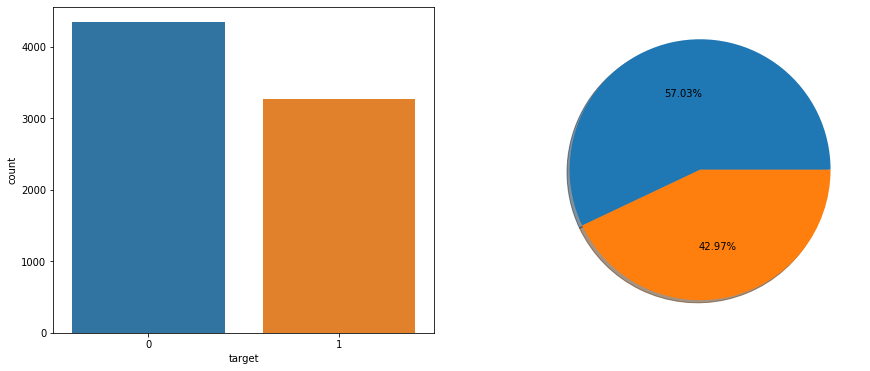

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(train_df['target'], ax=ax1)
ax2.pie(train_df['target'].value_counts(), autopct=lambda x: f'{x.round(2)}%', shadow=True);

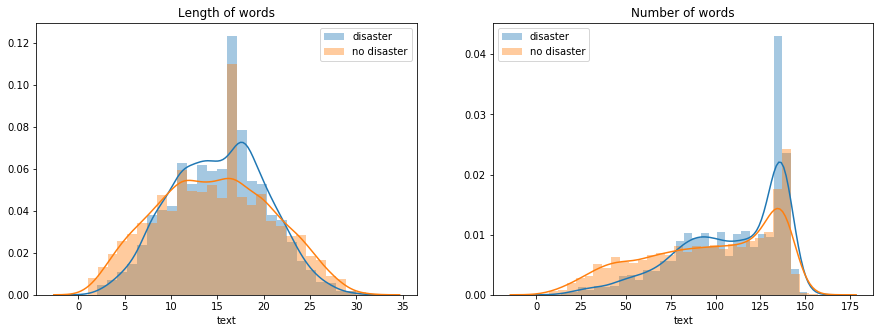

In [5]:
disaster = train_df.loc[train_df['target']==1]
no_disaster = train_df.loc[train_df['target']==0]
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(disaster['text'].str.split().apply(lambda x: len(x)), ax=ax[0], label='disaster')
sns.distplot(no_disaster['text'].str.split().apply(lambda x: len(x)), ax=ax[0], label='no disaster')
ax[0].legend()
ax[0].set_title('Length of words')

sns.distplot(disaster['text'].str.len(), ax=ax[1], bins=30, label='disaster')
sns.distplot(no_disaster['text'].str.len(), ax=ax[1], bins=30, label='no disaster')
ax[1].legend()
ax[1].set_title('Number of words');

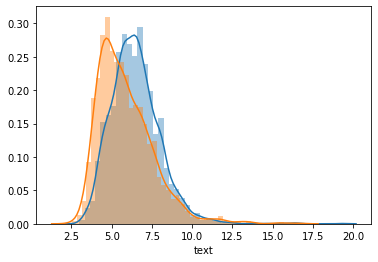

In [6]:
sns.distplot(disaster['text'].apply(lambda x: np.mean([len(i) for i in x.split()])))
sns.distplot(no_disaster['text'].apply(lambda x: np.mean([len(i) for i in x.split()])))

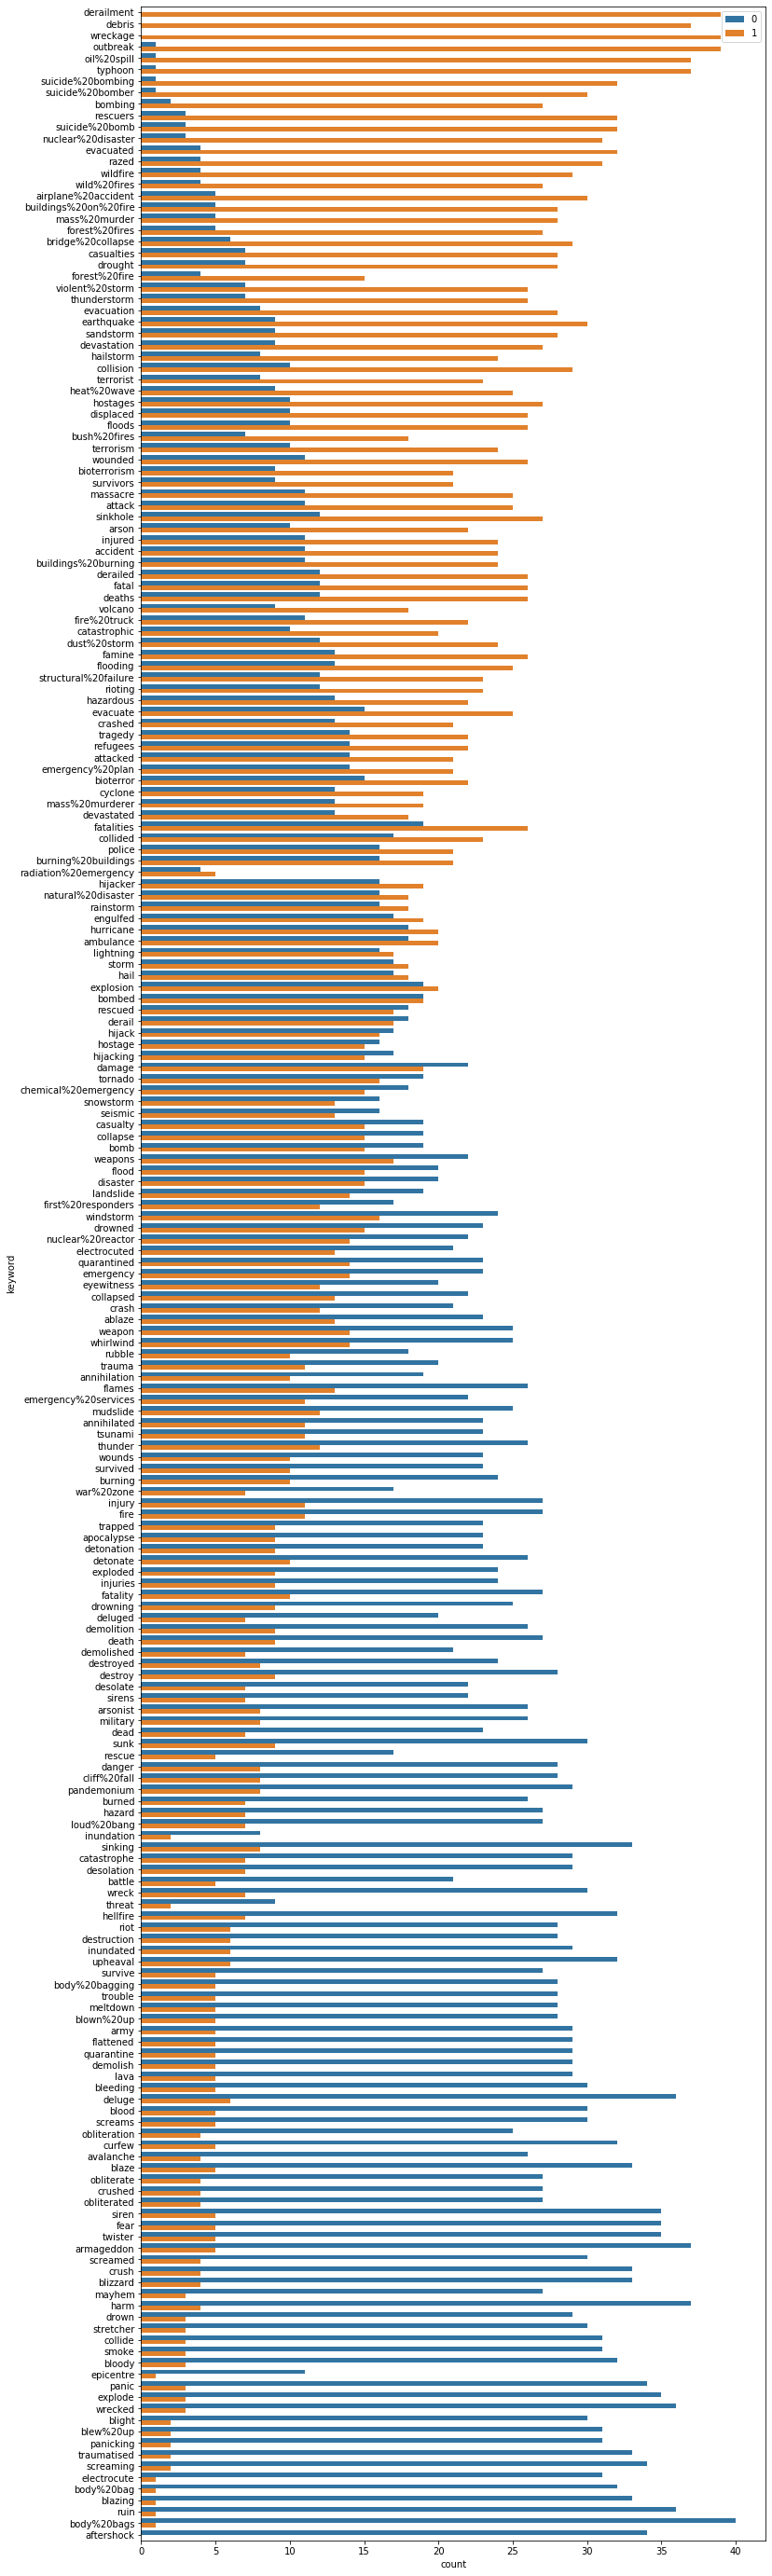

In [7]:
fig, ax = plt.subplots(figsize=(12, 50))
train_df['keyword_mean'] = train_df.groupby('keyword')['target'].transform('mean')
sns.countplot(y=train_df.sort_values(by='keyword_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='keyword_mean', ascending=False)['target'],
              ax=ax)
ax.tick_params(axis='y', labelsize=10)
ax.legend(loc='upper right')

## N-grams

In [32]:
def get_counter(train_df, target):
    text = train_df.loc[train_df['target']==target, 'text']
    all_text = " ".join(text.str.lower()).split()
    text_no_stops = [word for word in all_text if word not in stopwords if word not in string.punctuation]
    result = Counter(text_no_stops)
    result_df = pd.DataFrame(result.most_common(40), columns=['Word', 'Frequency'])
    return result_df.sort_values('Frequency')
    
disaster_counter = get_counter(train_df, 1)
nondisaster_counter = get_counter(train_df, 0)

<BarContainer object of 40 artists>

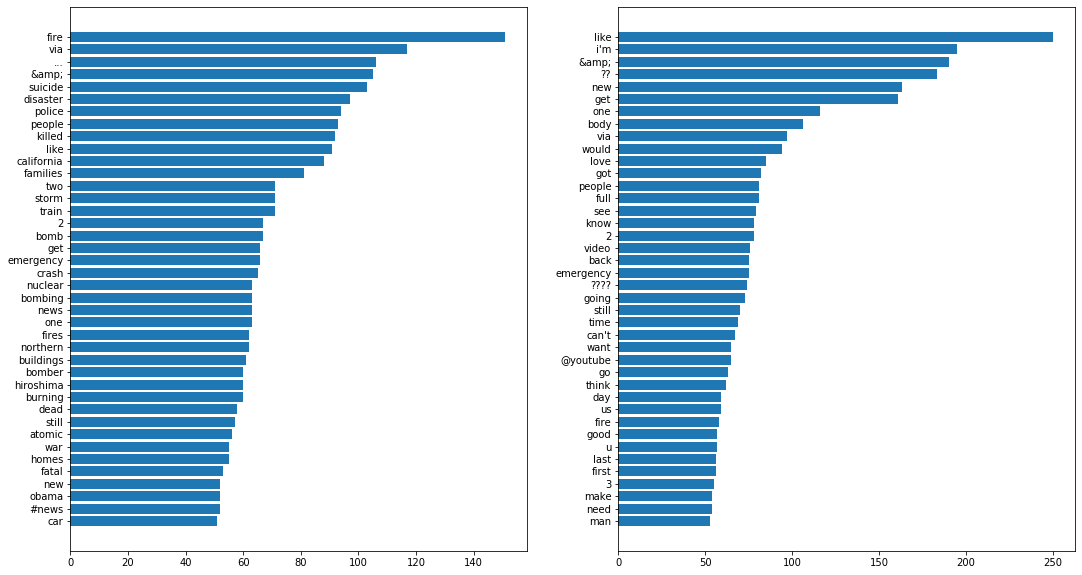

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
ax1.barh(disaster_counter['Word'], disaster_counter['Frequency'])
ax2.barh(nondisaster_counter['Word'], nondisaster_counter['Frequency'])

In [84]:
def get_ngrams(df, ngrams, num_words):
    vec = CountVectorizer(ngram_range=(ngrams,ngrams))
    count_words = vec.fit_transform(df['text'])
    count_words = count_words.toarray().sum(axis=0)
    word_arr = [(word, count_words[i]) for word, i in vec.vocabulary_.items()]
    word_arr.sort(key=lambda x: x[1])
    return pd.DataFrame(word_arr[-num_words:], columns=['word', 'count'])

<BarContainer object of 30 artists>

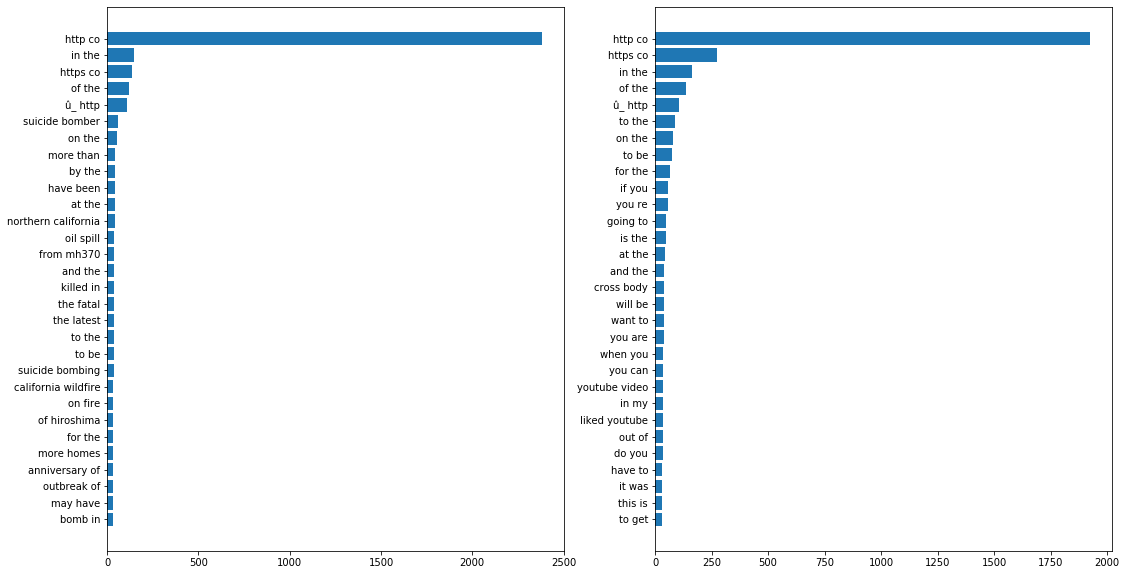

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
temp = get_ngrams(disaster, 2, 30)
nontemp = get_ngrams(no_disaster, 2, 30)
ax1.barh(temp['word'], temp['count'])
ax2.barh(nontemp['word'], nontemp['count'])

## Cleaning

In [93]:
def remove_url(text):
    rgx = re.compile(r'https?://\S+|www\.\S+')
    return rgx.sub('', text)

def remove_html(text):
    rgx = re.compile(r'<.*?>')
    return rgx.sub('', text)

def remove_emoticons(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df['text'] = train_df['text'].apply(remove_url)
train_df['text'] = train_df['text'].apply(remove_html)
train_df['text'] = train_df['text'].apply(remove_emoticons)

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610          M1.94 [01:04 UTC]?5km S of Volcano Hawaii. 
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object